# Reconstruction of DOSY NMR signals

## Part 1

### Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Style

In [15]:
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14

### Generation of synthetic data

#### Question 1

Download the diffusion signal $\overline{x} \in \mathbb{R}^N$ where $N=200$.

In [16]:
# Load data from text file
x = np.loadtxt("x.txt")
N = len(x)
print(f"The data has N={N} entries")

The data has N=200 entries


#### Question 2

Create $T$ using an exponential sampling strategy:
\begin{align}
\forall n \in \{1, \ldots, N\}, \quad T^{(n)} = T_{\min} \exp \big(- (n - 1) \frac{\log(T_\min / T_\max)}{N - 1} \big)
\end{align}
where $T_\min = 1$ and $T_\max = 1000$.


In [17]:
T_min = 1
T_max = 1000

# Create T using an exponential sampling strategy
T = np.array([T_min * np.exp(-(n - 1) * (np.log(T_min / T_max)) / (N - 1)) 
              for n in range(1, N + 1)])

#### Question 3

Display the original signal $\overline{x}$ as a function of $T$ (log scale on the horizontal axis).

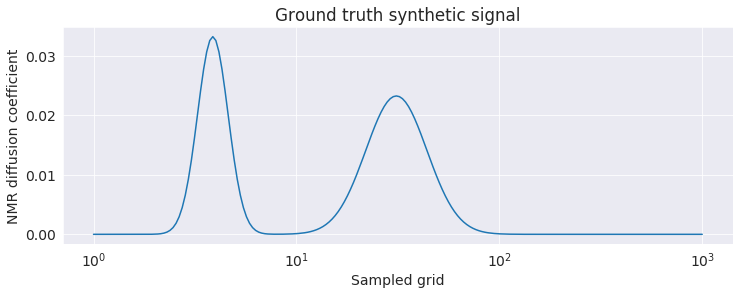

In [18]:
# Display the original signal x as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title("Ground truth synthetic signal")
plt.plot(T, x)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

#### Question 4

Create $t$ using a regular sampling strategy:
$$\forall m \in \{1, \ldots, M \}), \quad t^{(m)} = t_\min + \frac{m - 1}{M - 1} (t_\max - t_\min)$$
where $M=50$, $t_\min=0$ and $t_\max=1.5$.

In [19]:
M = 50
t_min = 0
t_max = 1.5

# Create t using a regular sampling strategy
t = np.array([t_min + (m - 1) / (M - 1) * (t_max - t_min) 
              for m in range(1, M + 1)])

#### Question 5

Construct matrix $K$ using:
$$\forall m \in \{1, \ldots, M \}, \; \forall n \in \{1, \ldots, N \}, \quad K^{(m, n)} = \exp(-T^{(n)}t^{(m)})$$

In [20]:
# Create the matrix K of size M x N
K = np.exp(- np.outer(t, T))

#### Question 6

Simulate the noisy data according to $y = K \overline{x} + w$ by taking $w \sim \mathcal{N}(0, \sigma^2 I_M)$ with $\sigma = 0.01 z^{(1)}$ where $z = K\overline{x}$

In [21]:
z = K.dot(x)
σ = 0.01 * z[0]

# Instanciate the noise
np.random.seed(42)
w = σ * np.random.randn(M)

# Simulate the noisy data
y = z + w

#### Question 7

Display the resulting noisy data $y$ as a function of $t$.

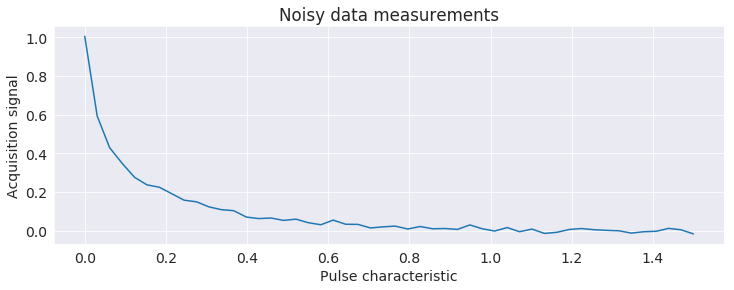

In [22]:
# Display the resulting noisy data y as a function of t
plt.figure(figsize=(12, 4))
plt.title("Noisy data measurements")
plt.plot(t, y)
plt.xlabel("Pulse characteristic")
plt.ylabel("Acquisition signal");

### Comparison of regularization strategies

For every penalization functions $g$ listed at the end of the document,
1. Discuss the existence and uniqueness of a solution to
$$ \hat{x} = \text{arg}\min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \beta g(x)$$
2. Propose an approach to solve the problem above.
3. Implement the approach and display the restored signal $\hat{x}$
4. Compute the normalized quadratic error between $\hat{x}$ and $\overline{x}$:
$$ E(\hat{x}, \overline{x}) = \frac{\parallel \hat{x} - \overline{x} \parallel^2}{\parallel \overline{x} \parallel^2}$$
5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

##### Normalized quadratic error implementation

In [23]:
def quadratic_error(x_hat, x):
    """
    Compute the normalized quadratic error between the restored signal
    and the ground truth signal
    
    Parameters
    ------------
    - x_hat : numpy.array
        Restored signal
        
    - x : numpy.array
        Ground truth signal
    
    Returns
    ------------
    - error : float
        Normalized quadratic error
    """
    
    error = np.linalg.norm(x_hat - x, ord=2)**2 / np.linalg.norm(x, ord=2)**2 
    return error

We will study three different priors

#### Smoothness prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2$$
where $D \in \mathbb{R}^{N \times N}$ is the discrete gradient operator defined such that:
$$\forall n \in \{1, \ldots, N \}, [Dx]^{(n)} = x^{(n)} - x^{(n-1)}$$
with the circular convention that $x^{(0)} = x^{(N)}$. The role of such regularization term is to promote the reconstruction of smooth signals.

#### Problem solution and approach

1. First we notice that the function $f: x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2 + \frac{\beta}{2} \parallel Dx \parallel^2$ is a **strictly convex** function by deriving its Hessian matrix $\nabla^2_f: x \mapsto K^T K + D^T D$. From here it appears that $\nabla^2_f$ is a **positive definite** matrix since we have: $\forall x \in \mathbb{R}^N \backslash\{0_{\mathbb{R}^N}\}, \; x^T \,\nabla^2_f(x)\, x = \parallel Kx \parallel^2 + \beta \parallel Dx \parallel^2 > 0$. 

In addition, we can check that the hessian matrix is invertible. We have that $\text{Ker} (K^T K + \beta D^T D) = \text{Ker} K \cap \text{Ker} D$, since given $x \in \text{Ker} (K^T K + \beta D^T D)$,

\begin{align}
(K^T K + \beta D^T D) x = 0 & \iff x^T (K^T K + \beta D^T D) x = 0 \\
& \iff K x = 0 \quad \text{and} \quad D x = 0\\
& \iff x \in \text{Ker} K \cap \text{Ker} D\\
\end{align}

By definition of $D$, we have $\forall x \in \text{Ker} D, Dx = 0 \iff x = \alpha 1_N$ where $1_N$ is a vector of dimension $N$ whose entries are only 1s and $\alpha$ is positive (?). Since $K$ is a matrix with only strictly positive coefficients by definition, we get: $\forall x \in \text{Ker} D, Kx > 0$, therefore $\text{Ker}(K) \cap \text{Ker}(D) = \{0_{\mathbb{R}^N}\}$ and the Hessian matrix is **invertible**.

2. As a result, we can directly compute the optimization problem **closed form** solution by solving the linear system induced by setting the gradient to 0, as follow:

$$\nabla_f(\hat{x}) = 0 \iff (K^T K + \beta D^T D) \hat{x} = K^T y \iff \boxed{\hat{x} = (K^T K + \beta D^T D)^{-1} K^T y}$$

Best normalized quadratic error between the original and reconstruction signals: 0.4029


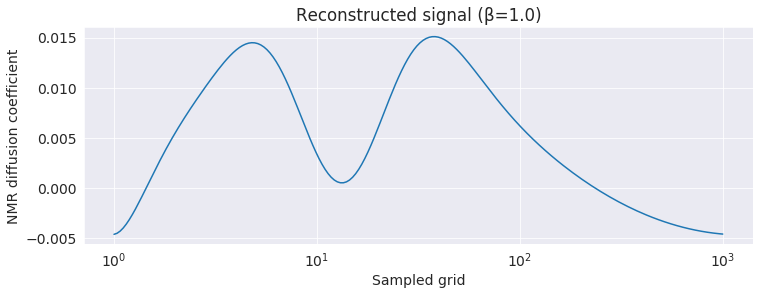

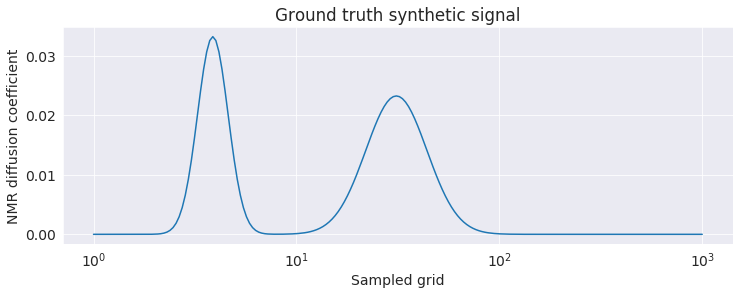

In [24]:
# Define D the discrete gradient operator
D = np.eye(N)
for i in range(N - 1):
    D[i+1, i] = -1
D[0, -1] = -1


# Search for the best parameter β
best_error = np.inf
best_x_hat = None
best_β = None

β_range = np.linspace(1, 100, num=50, endpoint=True)

for β in β_range:
    # Closed form solution
    x_hat = np.linalg.solve(K.T.dot(K) + β * D.T.dot(D), K.T.dot(y))
    # Compute the normalized quadratic error between x_hat and x
    error = quadratic_error(x_hat, x)
    
    # Update best settings
    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β
        
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title(f"Reconstructed signal (β={best_β})")
plt.plot(T, best_x_hat)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

# Display the original signal x as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title("Ground truth synthetic signal")
plt.plot(T, x)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

**Comment:**

We recovered two peaks although they do not occur for the same sample. In addition, the recovered peaks are not as sharp as the ground truth ones. Moreover we recover some negative values for the NMR diffusion coefficient which does not make sense on a physics standpoint. 

#### Smoothness prior + constraints


$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_\min, x_\max]^N}(x)$$
with $0 < x_\min < x_\max$ the minimum and maximum values of the original signal $\overline{x}$.

1. This time we add the function $\iota_{[x_\min, x_\max]^N}$ which is convex since $[x_\min, x_\max]^N$ is a convex set but is not strictly convex. As a result the function $x \mapsto \frac{1}{2}\parallel Kx - y \parallel^2 + \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_\min, x_\max]^N}(x)$ is **convex but not strictly convex**. 


2. This implies that we cannot derive a closed form solution and must rely on the **projected gradient algorithm**. Let us denote $g: x \mapsto \frac{1}{2}\parallel Kx - y \parallel^2 + \frac{1}{2} \parallel Dx \parallel^2$ and $f: x \mapsto \iota_{[x_\min, x_\max]^N}(x)$ to recover the notations seen in class in order to apply the Forward-Backward algorithm (specifically its projected gradient variant). 

We need to compute the $\nu$-Lipschitzian gradient where $\nu = \max(|a_i|)_{i \in \{1, \ldots, N\}}$ where the $a_i$ are the eigenvalues of the Hessian matrix of $g$ (i.e. $K^T K + \beta D^T D$) and the proximal operator of $\gamma f$ simply becomes the projection on the set $[x_\min, x_\max]^N$.

Best normalized quadratic error between the original and reconstruction signals: 0.2781


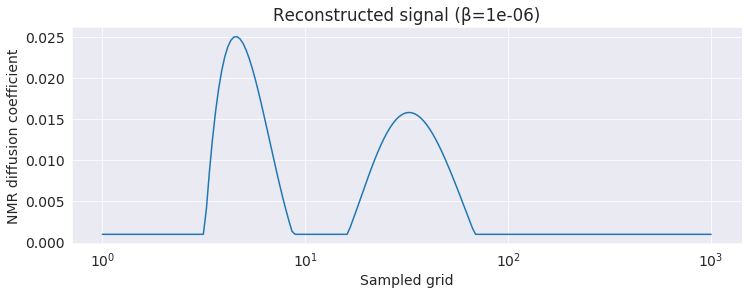

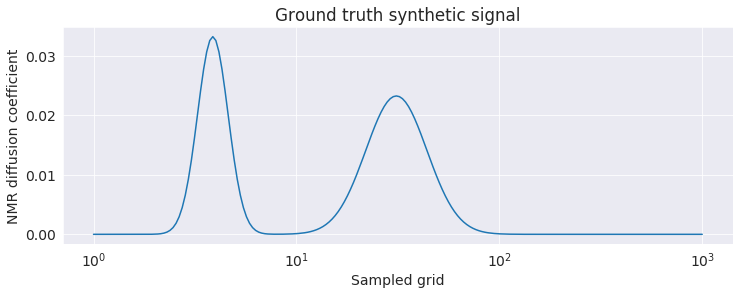

In [25]:
# Define D the discrete gradient operator
D = np.eye(N)
for i in range(N - 1):
    D[i+1, i] = -1
D[0, -1] = -1



# Set the clipping values
x_min = 1e-3
x_max = 1




# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
n_iter = 10000

β_range = np.linspace(1e-6, 1e-3, num=10, endpoint=True)

for β in β_range:
    
    # Compute the largest eigenvalues of the Hessian of g(x)
    # We use ``eigvalsh`` to only compute the eigenvalues
    # the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
    # to real symmetric matrices such as $K^T K + \beta D^T D$
    ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K) + β * D.T.dot(D)))[-1]

    # Set the step size
    γ = 1 / ν
    δ = 2 - γ * ν / 2
    λ = 0.95
    assert δ - λ > 0

    # Initialization
    x_curr = np.zeros_like(x)

    # Implement the Projected Gradient Algorithm
    for _ in range(n_iter):
        y_curr = x_curr - γ * (K.T.dot(K.dot(x_curr) - y) + β * D.T.dot(D.dot(x_curr)))
        x_next = x_curr + λ * (np.clip(y_curr, x_min, x_max) - x_curr)
        x_curr = x_next

    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title(f"Reconstructed signal (β={best_β})")
plt.plot(T, best_x_hat)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

# Display the original signal x as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title("Ground truth synthetic signal")
plt.plot(T, x)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

**Comment:**

We recover the two peaks and clearly see the effect of clipping on the minimal value of the reconstructed signal. Adding the boundaries constraints, we get a much better reconstruction error compared to using only the smoothness prior. That being said, the recovered peaks are still not as sharp as the ground truth ones.  

#### Sparsity prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \parallel x \parallel_1$$

Here we want to induce a parcimonious solution where only a few coefficients are non-null.

1. Here the function $x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2 + \parallel x \parallel_1$ is strictly convex but not differentiable. Hence there is a global minima but we cannot obtain it by setting the gradient to 0. 

2. The optimization problems consists in minimizing the **sum of two functions** that have different properties. To recover the notations from the course, let us note $f: x \mapsto \parallel x \parallel_1$ and $g: x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2_2$. Now $g$ is lower-semi-continuous, proper, convex and **differentiable** with a $\nu$-Lipschitzian gradient corresponding to the highest eigenvalue of the Hessian matrix $K^T K$ and $f$ is lower-semi-continuous, proper, convex and **separable** therefore we can easily compute its proximal operator and apply it element-wise.

We can now apply the Forward-Backward algorithm in its iterative soft-thresholding variant (ISTA).

Best normalized quadratic error between the original and reconstruction signals: 0.1277


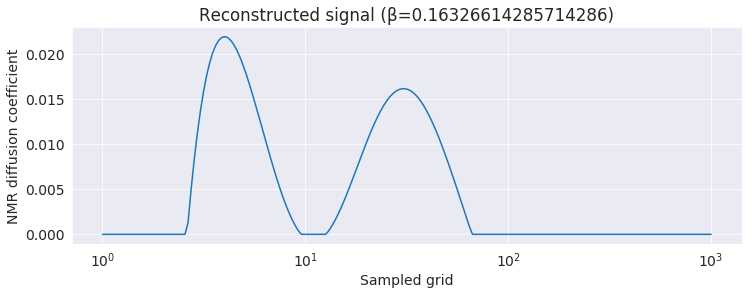

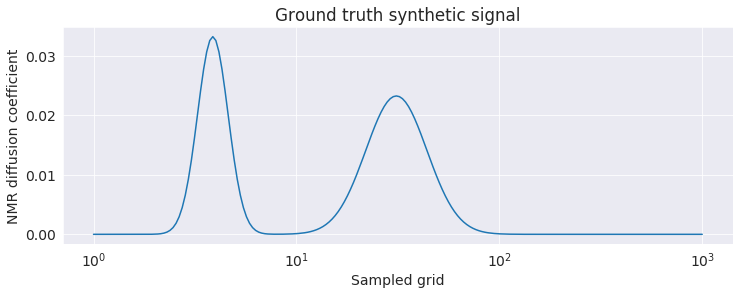

In [26]:
# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
n_iter = 10000

β_range = np.linspace(1e-6, 1, num=50, endpoint=True)

for β in β_range:
    # Compute the largest eigenvalues of the Hessian of g(x)
    # We use ``eigvalsh`` to only compute the eigenvalues
    # the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
    # to real symmetric matrices such as $K^T K$
    ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K)))[-1]

    # Set the step size
    γ = 1 / ν
    δ = 2 - γ * ν / 2
    λ = 0.95
    assert δ - λ > 0

    # Initialization
    x_curr = np.zeros_like(x)

    # Implement the Projected Gradient Algorithm
    for _ in range(n_iter):
        y_curr = x_curr - γ * K.T.dot(K.dot(x_curr) - y)
        # Thresholding
        x_next = x_curr + λ * (np.sign(y_curr) * np.maximum(np.abs(y_curr) - (β / 2 * γ), 0) - x_curr)
        x_curr = x_next

    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title(f"Reconstructed signal (β={best_β})")
plt.plot(T, best_x_hat)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

# Display the original signal x as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title("Ground truth synthetic signal")
plt.plot(T, x)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

**Comment:**

We clearly recover the two ground truth peaks. We get a better reconstruction error than in the two previous settings. The reconstructed signal is sparse as there are only a few coefficients that are non null. Since we have **prior knowledge** of the task at hand, that is recovering different species of molecules by looking at their Nuclear Magnetic Resonance diffusion coefficient, aiming for a **sparse solution appears to be a good idea**.

**Conclusion:**

Note however that these results based on synthetic data **highly depend on the noise** added to the ground truth measurement. We encountered instances of the problem where the smoothness + constraints (case 2) yielded a lower error than the sparsity prior. As a consequence, we **fixed the random seed** generating the noise to make the results reproducible.